In [2]:
# mount with the drive
import os
from google.colab import drive
drive.mount('/content/drive')

# # need to run only first time
main_path = os.path.join('drive', 'MyDrive')
result_path = os.path.join(main_path, 'MLData')
figure_path = os.path.join(main_path, 'MLData')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import scipy.io as sio 
from preprocessing_funcs import get_spikes_with_history
#from LSTM import LSTM
#from train import train
import torch.nn as nn
import torch 
import matplotlib.pyplot as plt



In [4]:
class LSTM(nn.Module):
    
    def __init__(self, TrainX, TrainY, n_hidden= 10 ,n_layers = 1, lr=0.001): # no dropout for now 
        super().__init__()
        self.n_hidden = n_hidden
        self.lr = lr
        self.n_layers = n_layers
        self.input_dim = TrainX.shape[2]
        self.output_dim = TrainY.shape[1]
        self.seq_len = TrainX.shape[1]
        self.batch_size = TrainX.shape[0]

        """self.net = nn.Sequential(nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True), 
                         nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True), 
                        nn.Linear(n_hidden, (TrainY.shape[1])))"""
        #lstm layers
        self.lstm = nn.LSTM(self.input_dim, self.n_hidden, self.n_layers, batch_first=False)
        self.lstm2 = nn.LSTM(self.n_hidden, self.n_hidden, self.n_layers, batch_first=False)
        #output layer
        self.fc = nn.Linear(self.n_hidden, self.output_dim)
    
    def binarize_weights(self, ind_layer): 
      net = self.lstm2
      tol = 1e-5
      if ind_layer == 0:
        net = self.lstm
      weights = net.weight_ih_l0
      for idx, w_ in enumerate(weights) : 
        with torch.no_grad():
          arr = net.weight_ih_l0[idx].numpy()
          arr = np.round(arr, 1)*10


          
    
    def forward(self, TrainX, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        ## Get the outputs and the new hidden state from the lstm
        #TrainX = TrainX.reshape([self.seq_len, self.batch_size, self.input_dim])
        new_input = torch.ones((self.seq_len, TrainX.shape[0], self.input_dim))
        for i in range(self.seq_len):
            new_input[i] = TrainX[:,i,:]
       
        TrainX = new_input
        #self.binarize_weights(0)
        r_output, hidden = self.lstm(TrainX, hidden)
        #self.binarize_weights(1)
        r_output, hidden = self.lstm2(r_output, hidden)
        # Stack up LSTM outputs using view
        # reshape the output
        #out = r_output.contiguous().view(-1, self.n_hidden)
       
        ## put x through the fully-connected layer
        #self.binarize_weights(2)
        out = self.fc(r_output)
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        hidden_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        hidden = (hidden_state, cell_state)

        return hidden

In [16]:
from torch.utils.data import Dataset, DataLoader, random_split
from FingerDataset import FingerDataset

def train(TrainX, TrainY,TestX, TestY, net, lossfunc, optimizer, num_epoch, clip = 5, finger =0):
    seq_len = TrainX.shape[1]
    train_length = int(0.8*len(TrainX))
    val_length = len(TrainX)-train_length
    train_data = TrainX[:train_length]
    val_data = TrainX[train_length:]
    train_label = TrainY[:train_length]
    val_label = TrainY[train_length:]
    list_corr_train = []
    list_corr_val = []
    list_corr_test = []
    
   
    for epoch in range(num_epoch):
        # TODO: Step 1 - create torch variables corresponding to features and labels
        

        #x = TrainX.reshape([seq_len, TrainX.shape[0],TrainX.shape[1]])
        x = torch.from_numpy(train_data).float()
        y = torch.from_numpy(train_label).float()
        xv = torch.from_numpy(val_data).float()
        yv = torch.from_numpy(val_label).float()
        xt = torch.from_numpy(TestX).float()
        yt = torch.from_numpy(TestY).float()
        # initialize hidden state 
        h = net.init_hidden(train_data.shape[0])
        hv = net.init_hidden(val_data.shape[0])
        ht = net.init_hidden(TestX.shape[0])
        # TODO: Step 2 - compute model predictions and loss
        pred, h = net(x, h)
        
        #target = torch.reshape(y, (-1,)).long()

        loss = lossfunc(pred[-1,:,:], y)
        #The main idea is to calculate the correlation as dot product between two features. Larger result indicates more similar
        #loss = corr_coeff(pred[-1,:,:], y)
        
        # TODO: Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping - prevents gradient explosion 
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        
        if True:#((epoch+1)%50 ==0) or (epoch+1==num_epoch):
            #print(pred[pred>0])
            
            corrcoef = np.corrcoef(pred[-1,:,:].detach().numpy().reshape((-1,)),y.detach().numpy().reshape((-1,)))
            list_corr_train += [corrcoef[0,1]]
            print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, loss.item()))
            print ('Correlation coefficient train : {corrcoef}'.format(corrcoef=corrcoef[0,1]))
            predv, hv = net(xv, hv)
            corrcoefv = np.corrcoef(predv[-1,:,:].detach().numpy().reshape((-1,)),yv.detach().numpy().reshape((-1,)))
            list_corr_val += [corrcoefv[0,1]]
            print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, loss.item()))
            print ('Correlation coefficient validation: {corrcoef}'.format(corrcoef=corrcoefv[0,1]))
            predt, ht = net(xt, ht)
            corrcoeft = np.corrcoef(predt[-1,:,:].detach().numpy().reshape((-1,)),yt.detach().numpy().reshape((-1,)))
            list_corr_test += [corrcoeft[0,1]]
            print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, loss.item()))
            print ('Correlation coefficient test: {corrcoef}'.format(corrcoef=corrcoeft[0,1]))
    return list_corr_train, list_corr_val, list_corr_test
    #prediction[finger] = pred[-1,:,:].detach().numpy().reshape((-1,))
    



In [17]:
# train using correlation coefficient for loss 
def corr_coeff(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    cost = torch.mean(vx * vy) / (torch.sqrt(torch.mean(vx ** 2)) * torch.sqrt(torch.mean(vy ** 2)))
    return (1/cost)

In [18]:
# preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()

def preprocessing(X, testX, Y, testY) : 
    
    # fit and transform the data 
    scaler_data = scaler.fit_transform(X)
    testX = scaler.transform(testX)
    #Y = scaler.fit_transform(Y)
    #testY = scaler.transform(testY)
    return scaler_data, testX, Y, testY

In [19]:
import pickle

for Idx_subject in list([10]): # 3 subjects index 10-12
        prediction = [[],[],[],[],[],[]]
        predictionTest = [[],[],[],[],[],[]]
        model = [[],[],[],[],[],[]]
        all_corrcoef = [[],[],[],[],[],[]]
        all_corrcoef_test = [[],[],[],[],[],[]]
        all_corrcoef_val = [[],[],[],[],[],[]]
        for Finger in list([0]): # 5 fingers for each subject. 0:thumb, 1:index, 2:middle ...
            
            #load training data (TrainX: feature vectors, TrainY: labels)
            matData = sio.loadmat(main_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMP.mat')
            TrainX = matData['Data_Feature'].transpose()
            TrainY = matData['SmoothedFinger']
            TrainY = TrainY [:,Finger]
            TrainY = TrainY.reshape(TrainY.shape[0],1)
            #load testing data (TestX: feature vectors, TestY: labels)
            matData = sio.loadmat(main_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMPTest.mat')
            TestX = matData['Data_Feature'].transpose()
            TestY = matData['SmoothedFinger']
            TestY = TestY[:,Finger]
            TestY = TestY.reshape(TestY.shape[0],1)
            
            # preprocessing 
            print("preprocessing...")
            TrainX,TestX,TrainY,TestY  = preprocessing(TrainX,TestX,TrainY,TestY)
            #TestX = preprocessing(TestX)
            
            # from here, we reconstruct the input by "looking back" a few steps
            bins_before= 20 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding
            
            TrainX=get_spikes_with_history(TrainX,bins_before,bins_after,bins_current)

            TrainX, TrainY = TrainX[bins_before:,:,:], TrainY[bins_before:,]
         
            TestX=get_spikes_with_history(TestX,bins_before,bins_after,bins_current)
            TestX, TestY = TestX[bins_before:,:,:], TestY[bins_before:,]
            
            # Now, we reconstructed TrainX/TestX to have a shape (num_of_samples, sequence_length, input_size)
            # You can fit this to the LSTM
            

            print("run for finger ", Finger)

            n_hidden = 20
            n_layers = 5
            n_epochs =  60 #CHANGE THIS

            net = LSTM(TrainX, TrainY,  n_hidden, n_layers)

            lossfunc = nn.MSELoss()

            optimizer = torch.optim.Adamax(net.parameters())
            corr_train, corr_val, corr_test = train(TrainX, TrainY,TestX,TestY, net, lossfunc, optimizer, num_epoch = 10, clip = 5, finger = Finger)
            net.eval()
            trainPred,h = net(torch.from_numpy(TrainX).float(), net.init_hidden(TrainX.shape[0]))
            prediction[Finger] = trainPred[-1,:,:].detach().numpy().reshape((-1,))
            corrcoef = np.corrcoef(prediction[Finger],TrainY.reshape((-1,)))
            all_corrcoef[Finger] = corr_train
            print ('Correlation coefficient train : {corrcoef}'.format(corrcoef=corrcoef[0,1]))
            # Preprocess the data may leed to better performance. e.g. StandardScaler 
            model[Finger] = net
            testPred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))
            predictionTest[Finger] = testPred[-1,:,:].detach().numpy().reshape((-1,))
            #predictionTest[Finger] = scaler.inverse_transform(predictionTest[Finger])
            corrcoef = np.corrcoef(predictionTest[Finger],TestY.reshape((-1,)))
            all_corrcoef_test[Finger] = corr_test
            all_corrcoef_val[Finger] = corr_val
            print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=corrcoef[0,1]))   
        with open(os.path.join(result_path, 'corrcoefNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as f:
          pickle.dump(all_corrcoef, f) 
        with open(os.path.join(result_path, 'corrcoef_valNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as f:
          pickle.dump(all_corrcoef_val, f)    
        with open(os.path.join(result_path, 'corrcoef_testNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as f:
          pickle.dump(all_corrcoef_test, f)  
        with open(os.path.join(result_path, 'predictionsNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as f:
          pickle.dump(prediction, f)
        with open(os.path.join(result_path, 'modelNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as fi:
          pickle.dump(model, fi)
        with open(os.path.join(result_path, 'testPredictionsNoBin_'+str(n_epochs)+'E_Sbj' + str(Idx_subject)), 'wb') as f:
          pickle.dump(predictionTest, f)
        

preprocessing...
run for finger  0
Epoch [1/10], Loss: 0.6916
Correlation coefficient train : -0.012026834498822293
Epoch [1/10], Loss: 0.6916
Correlation coefficient validation: -0.015068033052053445
Epoch [1/10], Loss: 0.6916
Correlation coefficient test: -0.02719547290064421
Epoch [2/10], Loss: 0.6763
Correlation coefficient train : 0.035300552451771786
Epoch [2/10], Loss: 0.6763
Correlation coefficient validation: -0.009137744295259272
Epoch [2/10], Loss: 0.6763
Correlation coefficient test: -0.0010878155561203286
Epoch [3/10], Loss: 0.6632
Correlation coefficient train : 0.07657609725948754
Epoch [3/10], Loss: 0.6632
Correlation coefficient validation: -0.005009413760896108
Epoch [3/10], Loss: 0.6632
Correlation coefficient test: 0.022066939672992673
Epoch [4/10], Loss: 0.6516
Correlation coefficient train : 0.11107186567929314
Epoch [4/10], Loss: 0.6516
Correlation coefficient validation: -0.0009051466343956346
Epoch [4/10], Loss: 0.6516
Correlation coefficient test: 0.0422806099

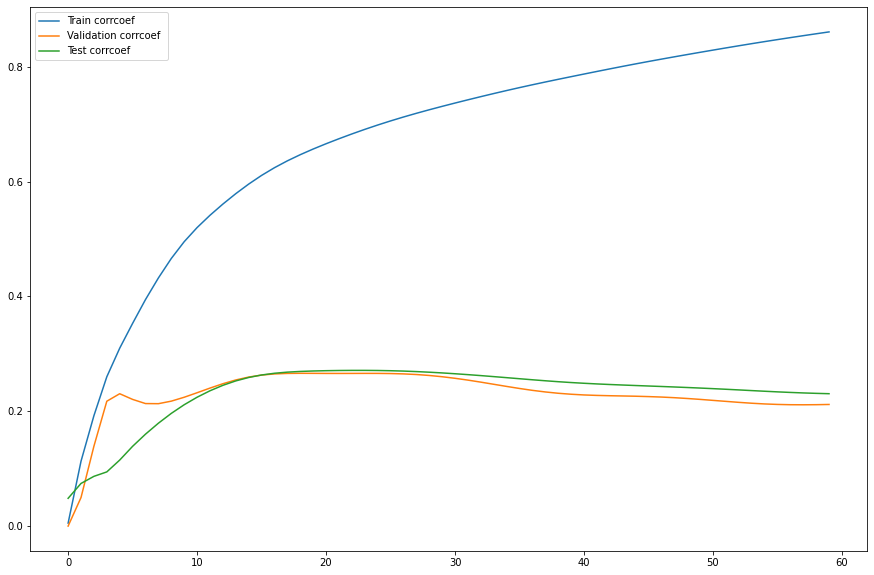

In [14]:
fig_corrcoef = plt.figure(figsize=(15,10))
#plt.plot(x[:], result[0][:], 'o')
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef_val[0])
plt.plot( all_corrcoef_test[0])
plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef_test)+' epochs no binarization subj 10 finger 0.png'), format='png')

In [ ]:
x = np.arange(TrainY.shape[0]-20)
prediction1 = scaler.inverse_transform(np.array(prediction[0]).reshape(-1, 1))
fig_pred = plt.figure(figsize=(15,10))
#plt.plot(x[:], result[0][:], 'o')
plt.plot( prediction1[2500:3400])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
#plt.plot(x[:], result[0][:], 'o')
plt.plot(x[2500:3400], TrainY[2500:3400, 0])

In [8]:
TrainY = matData['SmoothedFinger']
TrainYShifted = TrainY[20:,]

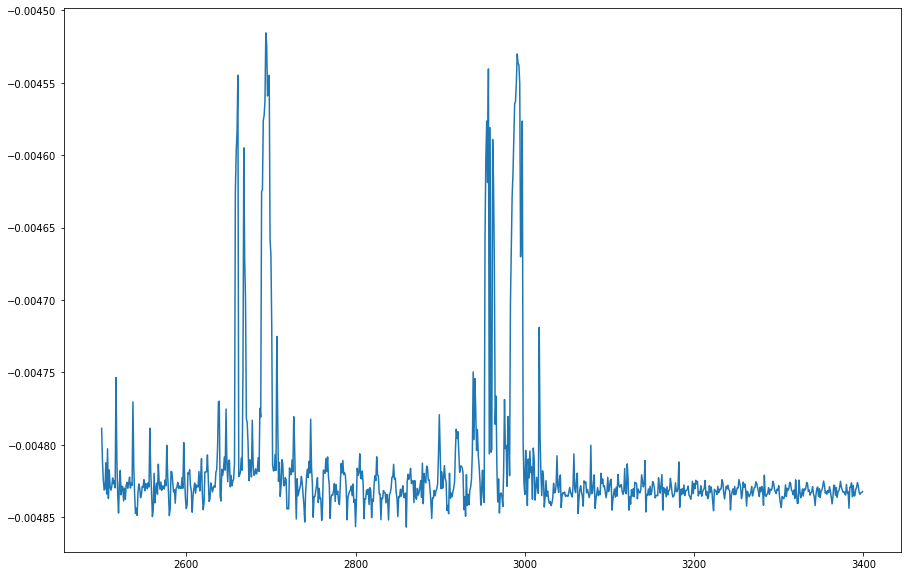

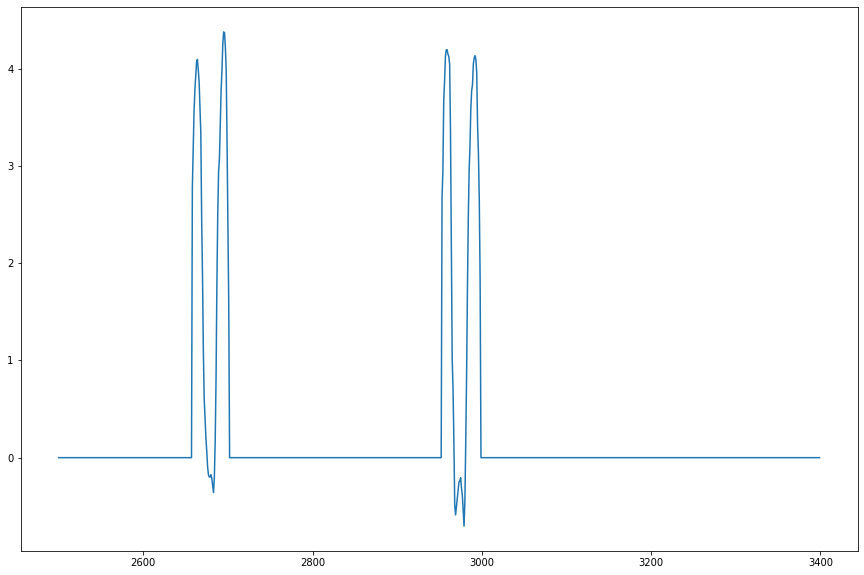

In [9]:
with open(os.path.join(result_path, 'predictionsNoBin_500E_Sbj11'), 'rb') as f:
    result = pickle.load(f)
x = np.arange(TrainYShifted.shape[0])
fig_pred = plt.figure(figsize=(15,10))
#plt.plot(x[:], result[0][:], 'o')
plt.plot(x[2500:3400], result[0][2500:3400])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
#plt.plot(x[:], result[0][:], 'o')
plt.plot(x[2500:3400], TrainYShifted[2500:3400, 0])

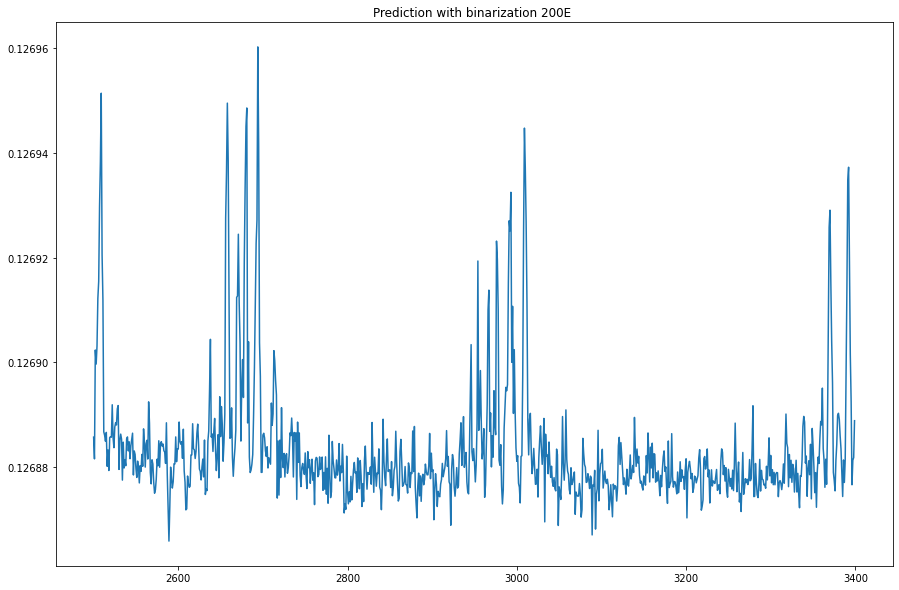

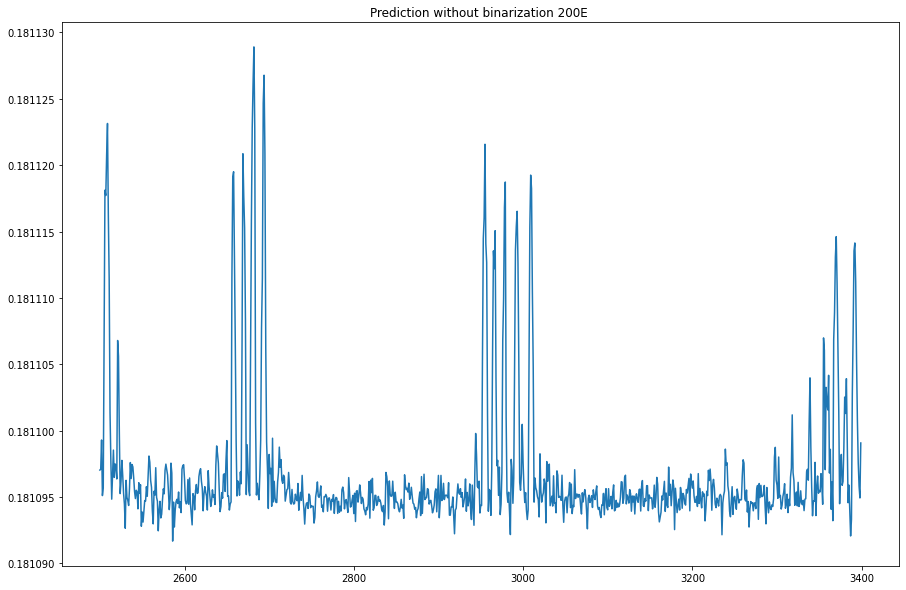

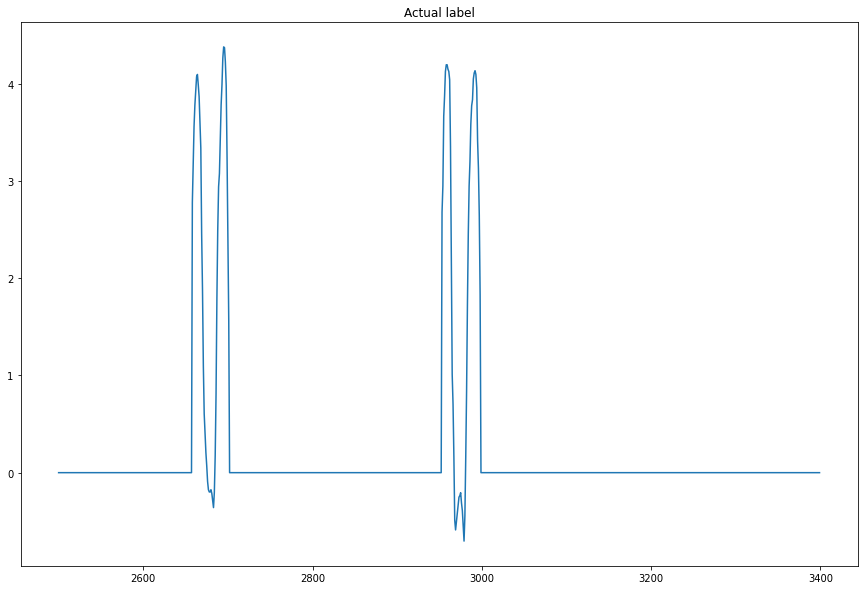

In [ ]:
with open(os.path.join(result_path, 'predictionsBin_200E_Sbj10'), 'rb') as f:
    resultBin200 = pickle.load(f)

with open(os.path.join(result_path, 'predictionsNoBin_500E_Sbj10'), 'rb') as f:
    resultNoBin200 = pickle.load(f)
x = np.arange(TrainYShifted.shape[0])
fig_bin = plt.figure(figsize=(15,10))
plt.title('Prediction with binarization 200E ')
plt.plot(x[2500:3400], resultBin200[2][2500:3400])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Prediction without binarization 200E ')
plt.plot(x[2500:3400], resultNoBin200[2][2500:3400])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title('Actual label')
plt.plot(x[2500:3400], TrainYShifted[2500:3400, 0])

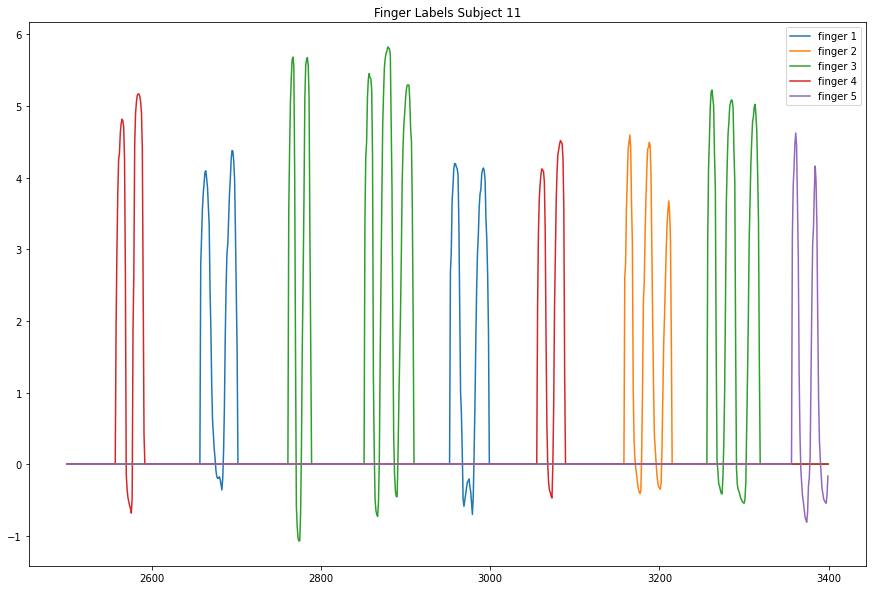

In [ ]:


x = np.arange(TrainY.shape[0])
labels = plt.figure(figsize=(15,10))
plt.title('Finger Labels Subject 11')
plt.plot(x[2500:3400], TrainYShifted[2500:3400,0])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,1])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,2])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,3])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,4])
plt.legend(["finger 1", "finger 2", "finger 3","finger 4","finger 5"])

(9996, 5)


Text(0.5, 0, 'Time')

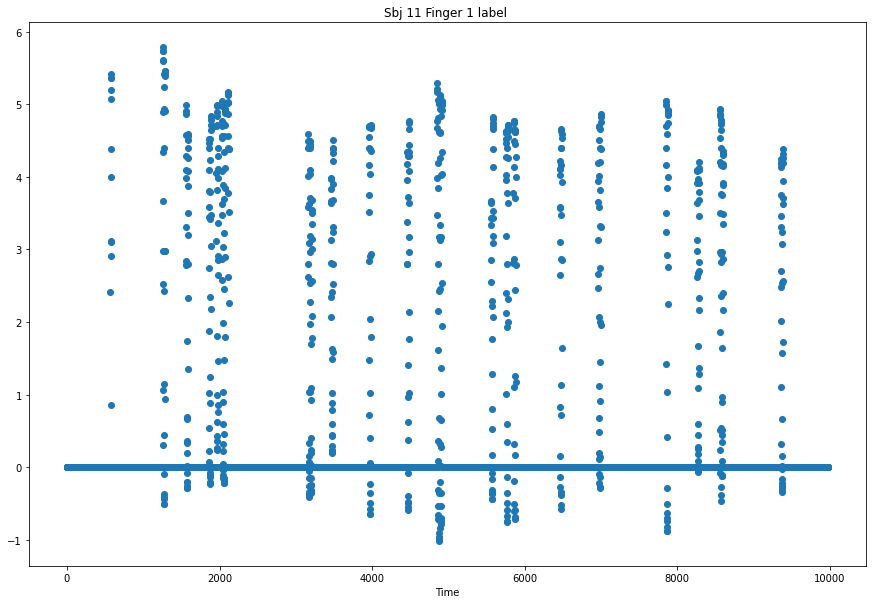

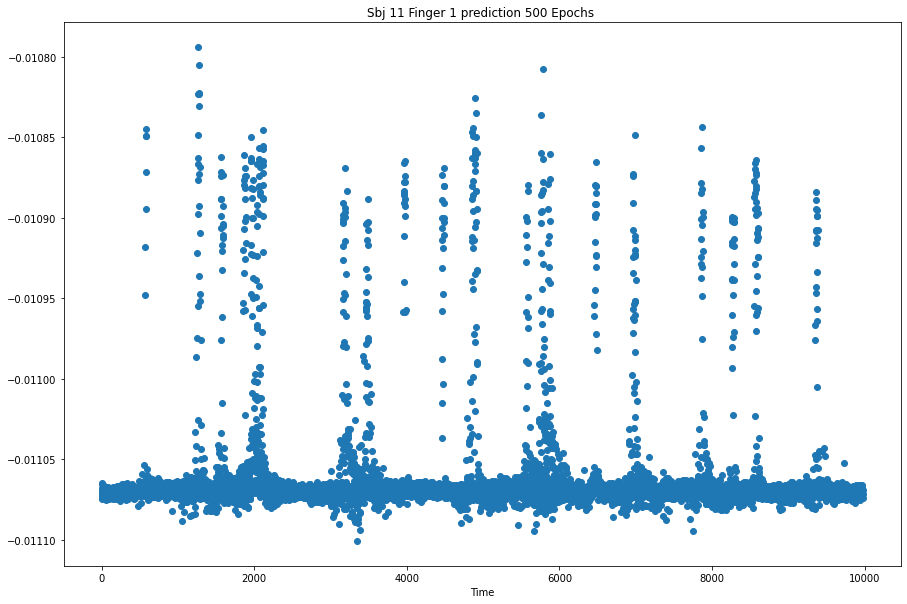

In [ ]:
x = np.arange(TrainYShifted.shape[0])

print(TrainY.shape)
fig1 = plt.figure(figsize=(15,10))
plt.plot(x[:], TrainYShifted[:,1],'o')
plt.title('Sbj 11 Finger 1 label ' );
plt.xlabel('Time')
fig1_res = plt.figure(figsize=(15,10))
plt.plot(x[:], result[1][:],'o')
plt.title('Sbj 11 Finger 1 prediction 500 Epochs ' );
plt.xlabel('Time')


Text(0.5, 0, 'Time')

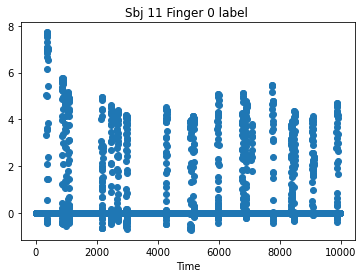

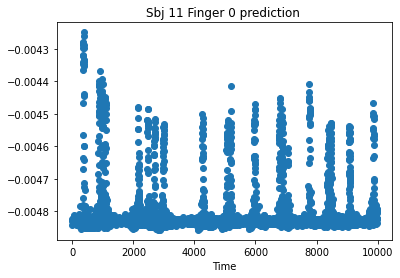

In [ ]:
fig2, ax = plt.subplots()
x = np.arange(TrainYShifted.shape[0])
#plt.figure(figsize=(15,10))
ax.plot(x[:], TrainYShifted[:,0], 'o')
ax.set_title('Sbj 11 Finger 0 label ' );
ax.set_xlabel('Time')

fig2_res, ax = plt.subplots()
ax.plot(x[:], result[0][:], 'o')
ax.set_title('Sbj 11 Finger 0 prediction ' );
ax.set_xlabel('Time')



In [ ]:
fig1.savefig(os.path.join(figure_path, 'Label F1 sbj11.png'), format='png')
fig1_res.savefig(os.path.join(figure_path, 'LSTM no binarization result 500 epochs F1 sbj11.png'), format='png')
fig2.savefig(os.path.join(figure_path, 'Label F0 sbj11 dots.png'), format='png')
fig2_res.savefig(os.path.join(figure_path, 'LSTM no binarization result 500 epochs F0 sbj11 dots.png'), format='png')
labels.savefig(os.path.join(figure_path, 'Labels sbj11.png'), format='png')

